In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [2]:
def load_or_sample_images(size, type, num_images, channel=None,
                   num_images_for_cov_estimation=10000, num_patches=50000, edge_crop=32, 
                   median_filter=False):
    """
    Generate samples from a distribution of images. Either direct experimental images or
    gaussian process images derived from experimental images.

    Parameters
    ----------
    size : int  size of images
    type : str  'led_array' for BSCCM images, 'stationary_GP' for gaussian process images derived
                from BSCCM images
    num_images : int  number of images to generate
    channel : str  channel to use for BSCCM images
    num_images_for_cov_estimation : int  number of BSCCM images to use for covariance estimation
    num_patches : int  number of patches to use for covariance estimation   
    edge_crop : int  number of pixels to crop from the edge of BSCCM images when estimating covariance
    median_filter : bool  whether to median filter BSCCM images
    """
    if type == 'stationary_GP':
        # Generate gaussian process images based on the statistics of LED array images of cells
        patch_size = size # the size of patches to estimate the covariance matrix from
        images = load_bsccm_images(bsccm, channel, num_images=num_images_for_cov_estimation, 
                                   edge_crop=edge_crop, convert_units_to_photons=True, median_filter=median_filter)
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, seed=1234)
        print('computing cov mat')
        cov_mat = compute_stationary_cov_mat(patches)
        mean = np.mean(patches)
        print('making positive definite')
        cov_mat = make_positive_definite(cov_mat, cutoff_percentile=25, show_plot=False)
        # ensure that it is a valid covariance matrix
        non_symmetric_deviation = np.abs(cov_mat - cov_mat.T)
        if np.any(non_symmetric_deviation > 0):
            percentage_error = non_symmetric_deviation / np.mean(cov_mat)
            warnings.warn(f'Making covariance matrix symmetric, current deviation is {np.max(percentage_error)}% of the mean')
            cov_mat = (cov_mat + cov_mat.T) / 2

        images, patches = None, None # free memory
        # generate images

        images = generate_stationary_gaussian_process_samples(cov_mat, size, num_images, mean=mean, ensure_nonnegative=True)
        
        return np.array(images), cov_mat
    elif type == 'led_array':
        # load median filtered images of cells from LED array
        crop_size = bsccm.global_metadata['led_array']['image_shape'][0] - 2 * edge_crop
        images = load_bsccm_images(bsccm, channel, num_images=num_images, 
                                   edge_crop=edge_crop, convert_units_to_photons=True,
                                   median_filter=median_filter)
        # for each image, crop to a random square patch
        num_images = images.shape[0]
        cropped_images = []
        for image in images:
            # choose a random location to crop from
            x = onp.random.randint(0, crop_size - size)
            y = onp.random.randint(0, crop_size - size)
            # crop the image
            cropped_images.append(image[y:y + size, x:x + size])
        return np.array(cropped_images)
    else:
        raise ValueError('type must be led_array or stationary_GP')

## Is H(Y | X) well approximated by H(Y_theoretical | Y_experimental)

### Load images

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:47<00:00, 15.79s/it]


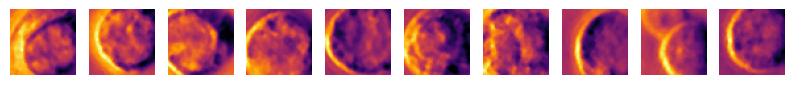

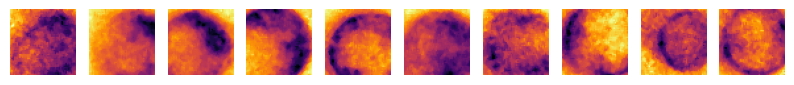

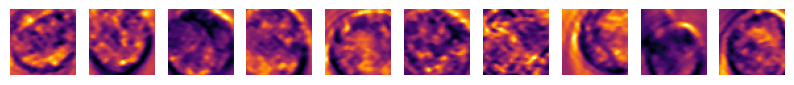

In [11]:
size = 50
num_images = 10000
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']

images = {}
for channel in tqdm(channels):
    images[channel] = load_or_sample_images(size, 'led_array', num_images, channel=channel, median_filter=True, edge_crop=32)
    # images, cov_mat = create_images(size, 'stationary_GP', num_images, channel=channel, median_filter=True, edge_crop=32)  

    if np.min(images[channel]) < 0:
        raise ValueError('images must be nonnegative')

    # plot a montage of images
    num_to_plot = 10
    fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
    for i in range(num_to_plot):
        ax[i].imshow(images[channel][i], cmap='inferno')
        ax[i].axis('off')

### Compare conditional entropy of noisy to clean

In [ ]:
mean_photons = {channel: np.mean(images[channel]) for channel in images.keys()}

results = {}
for channel in channels:
    results[channel] = {}
    for photons_per_pixel in tqdm(onp.linspace(20, 300, 10)):
        rescale_fractions = {channel: photons_per_pixel / mean_photons[channel] for channel in images.keys()}
        clean_images = images[channel] * rescale_fractions[channel]
        noisy_images = np.array(add_shot_noise(clean_images))
        mutual_information_noisy_conditional = estimate_mutual_information(noisy_images=noisy_images, cutoff_percentile=20) 
        mutual_information_true_conditional = estimate_mutual_information(noisy_images=noisy_images, clean_images=clean_images,
                                                                          cutoff_percentile=20) 
        results[channel][photons_per_pixel] = {'noisy': mutual_information_noisy_conditional,
                                                  'true': mutual_information_true_conditional}

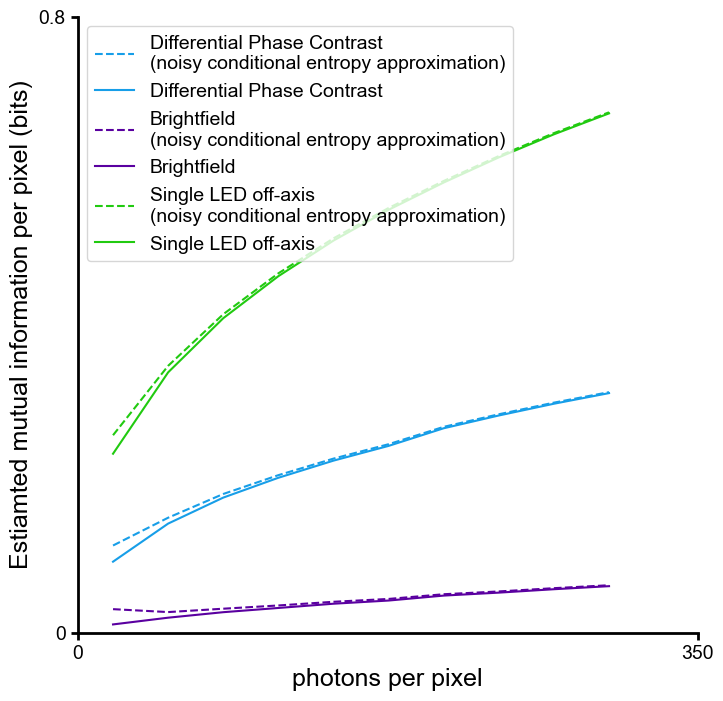

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = get_color_cycle()
for color, (channel, channel_results) in zip(colors, results.items()):
    channel_name = get_display_channel_names(channel)
    photons_per_pixel = list(channel_results.keys())
    ax.plot(photons_per_pixel, [r['noisy'] for r in channel_results.values()], '--',label=channel_name + '\n(noisy conditional entropy approximation)', color=color)
    ax.plot(photons_per_pixel, [r['true'] for r in channel_results.values()], '-', label=channel_name , color=color)
default_format(ax)
ax.set(xlabel='photons per pixel', ylabel='Estiamted mutual information per pixel (bits)')
ax.legend()

## Computing conditional entropy from the raw samples vs a stationary process approximation of the samples

In [5]:
size = 50
num_images = 10000
photons_per_pixel = 200
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']

experimental_images = {}
stationary_process_samples = {}
for channel in tqdm(channels):
    experimental_images[channel] = load_or_sample_images(size, 'led_array', num_images, channel=channel, median_filter=True, edge_crop=32)
    samples, cov_mat = load_or_sample_images(size, 'stationary_GP', num_images, channel=channel, median_filter=True, edge_crop=32)  
    stationary_process_samples[channel] = samples
    for im in [experimental_images[channel], stationary_process_samples[channel]]:
        if np.min(im) < 0:
            raise ValueError('images must be nonnegative')

mean_photons = {channel: np.mean(experimental_images[channel]) for channel in experimental_images.keys()}
results = {}
for channel in tqdm(channels):
    rescale_fractions = photons_per_pixel / mean_photons[channel]
    noisy_images = np.array(add_shot_noise(experimental_images[channel] * rescale_fractions[channel]))
    noisy_stationary_process_samples = np.array(add_shot_noise(stationary_process_samples[channel] * rescale_fractions[channel]))

    mi_experimental = estimate_mutual_information(noisy_images) 
    mi_stationary = estimate_mutual_information(noisy_images, clean_images=noisy_stationary_process_samples)
    results[channel] = {'experimental': mi_experimental, 'stationary': mi_stationary}


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:00<00:00, 932245.72it/s]


computing cov mat


100%|██████████| 99/99 [00:02<00:00, 34.84it/s]
/tmp/ipykernel_24998/2370822704.py:35: UserWarning: Making covariance matrix symmetric, current deviation is 0.0022873040288686752% of the mean
  warnings.warn(f'Making covariance matrix symmetric, current deviation is {np.max(percentage_error)}% of the mean')


making positive definite
Matrix not positive definite. Adding 93.9415054321289 to eigenvalues
precomputing masks and variances


100%|██████████| 50000/50000 [00:00<00:00, 909259.29it/s]


computing cov mat


100%|██████████| 99/99 [00:02<00:00, 34.94it/s]
/tmp/ipykernel_24998/2370822704.py:35: UserWarning: Making covariance matrix symmetric, current deviation is 0.0011833958560600877% of the mean
  warnings.warn(f'Making covariance matrix symmetric, current deviation is {np.max(percentage_error)}% of the mean')


making positive definite
Matrix not positive definite. Adding 26.421173095703125 to eigenvalues
precomputing masks and variances


100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


In [ ]:
# create sample data
channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
experimental_data = [10, 20, 30]
non_experimental_data = [15, 25, 35]

# create a paired bar plot of results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = get_color_cycle()

# set the width of the bars
bar_width = 0.35

# create the bar plots
experimental_bars = ax.bar(np.arange(len(channel_names)), experimental_data, width=bar_width, color=colors[0], label='Experimental')
non_experimental_bars = ax.bar(np.arange(len(channel_names)) + bar_width, non_experimental_data, width=bar_width, color=colors[1], label='Non-experimental')

# add labels, title, and legend
ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2)
ax.set_xticklabels(channel_names)
ax.set_ylabel('Data')
ax.set_title('Experimental vs Non-experimental Data')
ax.legend()

## Compute bootstrapped confidence interval

100%|██████████| 5000/5000 [00:00<00:00, 672811.04it/s]


Estimated H(Y|X) = 5.147 bits/pixel
Estimated H(Y) = 5.129 bits/pixel
Estimated I(Y;X) = -0.018 bits/pixel
-0.018169403


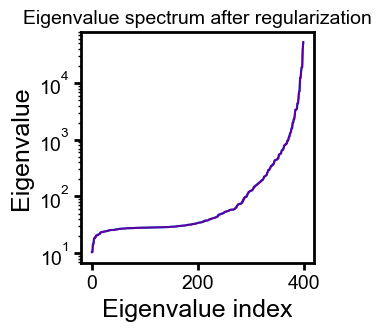

In [17]:
edge_crop = 32
patch_size = 20

num_images = 5000
num_patches = 5000


photons_per_pixel = 80

channel = 'LED119'


images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)
noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
patches *= photons_per_pixel / np.mean(images)

mi_mean = estimate_mutual_information(noisy_patches, show_eigenvalue_plot=True, add_to_eigenvalues=1e-5, confidence_interval=None)
print(mi_mean)

H_x = 4.060535907745361, H_y = 4.96438455581665, H_y_given_x = 5.148677825927734, I = -0.18429327011108398


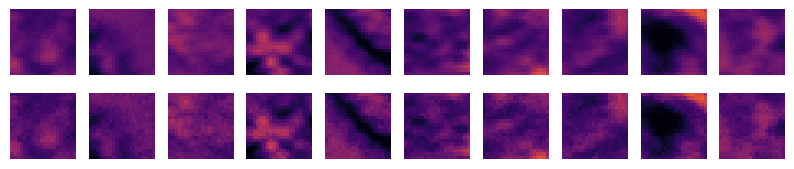

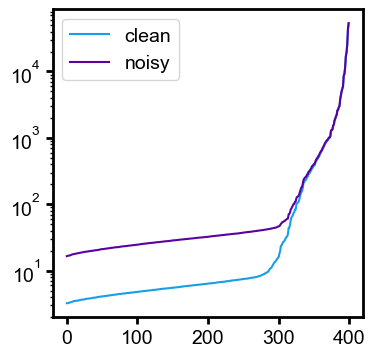

In [38]:
# plot noisy and clean patches
num_to_plot = 10
fig, ax = plt.subplots(2, num_to_plot, figsize=(num_to_plot, 2))
vmin, vmax = np.min(patches), np.max(patches)
for i in range(num_to_plot):
    ax[0, i].imshow(patches[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[0, i].axis('off')
    ax[1, i].imshow(noisy_patches[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[1, i].axis('off')

# vectorize both
patches_vec = patches.reshape(patches.shape[0], -1)
noisy_patches_vec = noisy_patches.reshape(noisy_patches.shape[0], -1)
D = patches_vec.shape[1]

# compute covariance matrices
cov_mat = np.cov(patches_vec.T - np.mean(patches_vec.T, axis=1, keepdims=True))
noisy_cov_mat = np.cov(noisy_patches_vec.T - np.mean(noisy_patches_vec.T, axis=1, keepdims=True))

# compute eigenvalues
eigvals = np.linalg.eigvalsh(cov_mat)
noisy_eigvals = np.linalg.eigvalsh(noisy_cov_mat)

# plot both eigenvalue distributions together
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.semilogy(eigvals, label='clean')
ax.semilogy(noisy_eigvals, label='noisy')
ax.legend()

# take logsum
sum_log_evs = np.sum(np.log(eigvals))
noisy_sum_log_evs = np.sum(np.log(noisy_eigvals))

H_x = 0.5 *(sum_log_evs + D * np.log(2* np.pi * np.e))
H_y = 0.5 *(noisy_sum_log_evs + D * np.log(2* np.pi * np.e))

a = 0.5 * np.log(2* np.pi * np.e) + np.log(np.sqrt(patches_vec))
b = np.sum(a, axis=1)
c = np.mean(b)

H_y_given_x = np.mean((D / 2 * np.log(2 * np.pi * np.e) + np.sum(np.log(np.sqrt(patches_vec)), axis=1)))

# make bits per pixel versions
H_x_bpp = H_x / D / np.log(2)
H_y_bpp = H_y / D / np.log(2)
H_y_given_x_bpp = H_y_given_x / D / np.log(2)

# print(f'H_x = {H_x}, H_y = {H_y}, H_y_given_x = {H_y_given_x}')
# print mutual information
# print(f'I = {H_y - H_y_given_x}')

#print bits per pixel
print(f'H_x = {H_x_bpp}, H_y = {H_y_bpp}, H_y_given_x = {H_y_given_x_bpp}, I = {H_y_bpp - H_y_given_x_bpp}')


# print('now the funciton')
# estimate_mutual_information(noisy_patches, show_eigenvalue_plot=True, 
#     add_to_eigenvalues=1e-5, verbose=True, use_stationary_model=False)


In [39]:
edge_crop = 24
patch_size = 20

num_images = 5000
num_patches = 10000

photons_per_pixel_values = onp.linspace(20, 300, 5)

channel = 'LED119'
confidence_interval = 90


images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

mi_means = []
mi_confidences = []

for photons_per_pixel in tqdm(photons_per_pixel_values):
    noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))

    mi_mean, mi_confidence = estimate_mutual_information(noisy_patches, show_eigenvalue_plot=False, cutoff_percentile=20, 
                                                         confidence_interval=confidence_interval, num_bootstrap_samples=100)
    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)

mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = get_color_cycle()
ax.plot(photons_per_pixel_values, mi_means, color=colors[0])
ax.fill_between(photons_per_pixel_values, onp.array(mi_confidences)[:, 0], onp.array(mi_confidences)[:, 1], color=colors[0], 
                alpha=0.5, label=f'{confidence_interval}% confidence interval')
clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estimated mutual information per pixel (bits)')
# show legend fo confidence interval
ax.legend()

100%|██████████| 5/5 [02:56<00:00, 35.27s/it]


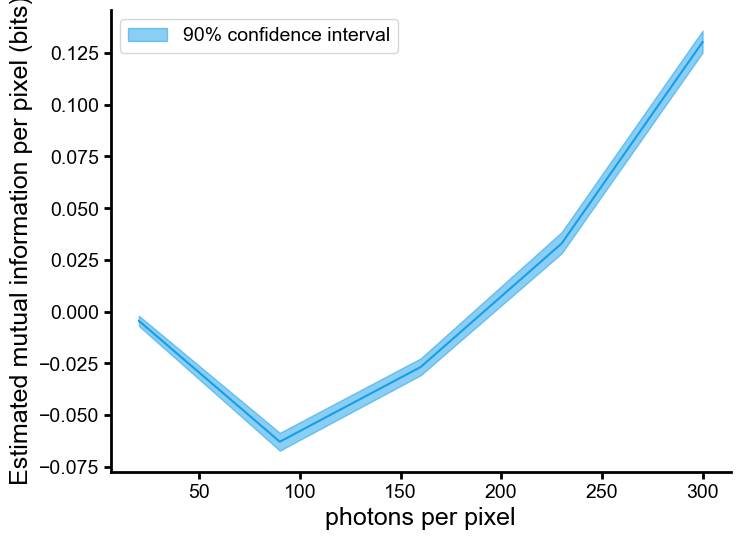

In [40]:


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = get_color_cycle()
ax.plot(photons_per_pixel_values, mi_means, color=colors[0])
ax.fill_between(photons_per_pixel_values, onp.array(mi_confidences)[:, 0], onp.array(mi_confidences)[:, 1], color=colors[0], alpha=0.5, label='90% confidence interval')
clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estimated mutual information per pixel (bits)')
# show legend fo confidence interval
ax.legend()



## Mutual information estimates and sample quality vs patch size 

## Dataset size vs need for regularization and variance of estiamte
look at eigenvalue plots and error bars

## Eigenvalue spectrum and dataset size needed